In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from Utils import SegGen
from sklearn.model_selection import KFold
import numpy as np
import shutil

Direcciones de imagenes de entrenamiento

In [7]:
# Dirección de carpetas para entrenamiento
train_path_rx =  'Data/Segmentacion/train/inputs' 
train_path_mask = 'Data/Segmentacion/train/targets'

# Dirección de carpetas para validación
validation_path_rx =  'Data/Segmentacion/validation/inputs' 
validation_path_mask = 'Data/Segmentacion/validation/targets'

# Dirección de carpetas para entrenamiento
test_path_rx =  'Data/Segmentacion/test/inputs' 
test_path_mask = 'Data/Segmentacion/test/targets'

# Lista de imagenes dentro de las carpetas
train_ids = np.array(os.listdir(train_path_rx))
validation_ids = np.array(os.listdir(validation_path_rx))
test_ids = np.array(os.listdir(test_path_rx))

path_save_modelos = "Models/Sementacion/Validacion"


Creación del modelo unet

In [3]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c
     

def UNet(image_size,f = [16, 32, 64, 128, 256], activation = 'sigmoid'):

    inputs = keras.layers.Input((image_size, image_size, 1))

    p0 = inputs
    c1, p1 = down_block(p0, f[0])  # 128 --> 64
    c2, p2 = down_block(p1, f[1])  # 64  --> 32
    c3, p3 = down_block(p2, f[2])  # 32  --> 16
    c4, p4 = down_block(p3, f[3])  # 16  --> 8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3])  # 8  --> 16
    u2 = up_block(u1, c3, f[2])  # 16 --> 32
    u3 = up_block(u2, c2, f[1])  # 32 --> 64
    u4 = up_block(u3, c1, f[0])  # 64 --> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation= activation)(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
Acuracy = []
Loss = []

In [1]:
model_name =  'Unet_Sigmoid_1'      # Nombre del modelo
image_size = 256                    # Tamano de las imágenes
batch_size = 8                      # Tamano del batch
f = [64, 128, 256, 512, 1024]       # Numéro de capas convolucionales
activation = 'sigmoid'              # Función de activación
adam_value = 0.00005                # Valor Adam
epochs = 5                         # Número de épocas
Adam = keras.optimizers.Adam(learning_rate=adam_value)

# Generación de datos a partir de función
train_gen = SegGen(train_ids, train_path_rx, train_path_mask, batch_size=batch_size, image_size=image_size)
valid_gen = SegGen(validation_ids, validation_path_rx, validation_path_mask, batch_size=batch_size, image_size=image_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(validation_ids)//batch_size

model = UNet( image_size, f , activation)  # Creación del modelo U-Net
model.compile(optimizer=Adam, loss="binary_crossentropy", metrics=["acc"])  # Ajuste de hiperparametros
# Entrenamiento del modelo
history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs, verbose=1)

Acuracy.append(history.history['val_acc'])
Loss.append(history.history['val_loss'])

path_save = os.path.join(path_save_modelos,model_name + '.keras') # Guardado del modelo
model.save(path_save)

NameError: name 'keras' is not defined

In [5]:
model_name =  'Unet_Sigmoid_2'   # Nombre del modelo
image_size = 256                    # Tamano de las imágenes
batch_size = 8                      # Tamano del batch
f = [64, 128, 256, 512, 1024]       # Numéro de capas convolucionales
activation = 'sigmoid'              # Función de activación
adam_value = 0.00001                # Valor Adam
epochs = 5                         # Número de épocas
Adam = keras.optimizers.Adam(learning_rate=adam_value)

# Generación de datos a partir de función
train_gen = SegGen(train_ids, train_path_rx, train_path_mask, batch_size=batch_size, image_size=image_size)
valid_gen = SegGen(validation_ids, validation_path_rx, validation_path_mask, batch_size=batch_size, image_size=image_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(validation_ids)//batch_size

model = UNet( image_size, f , activation)  # Creación del modelo U-Net
model.compile(optimizer=Adam, loss="binary_crossentropy", metrics=["acc"])  # Ajuste de hiperparametros
# Entrenamiento del modelo
history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs, verbose=1)

Acuracy.append(history.history['val_acc'])
Loss.append(history.history['val_loss'])

path_save = os.path.join(path_save_modelos,model_name + '.keras')  # Guardado del modelo
model.save(path_save)

Epoch 1/5
2714/2714 [==============================] - 1111s 408ms/step - loss: 0.1499 - acc: 0.9363 - val_loss: 0.0751 - val_acc: 0.9703
Epoch 2/5
2714/2714 [==============================] - 455s 168ms/step - loss: 0.0656 - acc: 0.9745 - val_loss: 0.0957 - val_acc: 0.9649
Epoch 3/5
2714/2714 [==============================] - 454s 167ms/step - loss: 0.0520 - acc: 0.9797 - val_loss: 0.0549 - val_acc: 0.9783
Epoch 4/5
2714/2714 [==============================] - 454s 167ms/step - loss: 0.0443 - acc: 0.9824 - val_loss: 0.0502 - val_acc: 0.9801
Epoch 5/5
2714/2714 [==============================] - 454s 167ms/step - loss: 0.0401 - acc: 0.9840 - val_loss: 0.0486 - val_acc: 0.9808


In [7]:
model_name =  'Unet_Tanh_1'   # Nombre del modelo
image_size = 256                    # Tamano de las imágenes
batch_size = 8                      # Tamano del batch
f = [64, 128, 256, 512, 1024]       # Numéro de capas convolucionales
activation = 'tanh'              # Función de activación
adam_value = 0.00005                # Valor Adam
epochs = 5                         # Número de épocas
Adam = keras.optimizers.Adam(learning_rate=adam_value)

# Generación de datos a partir de función
train_gen = SegGen(train_ids, train_path_rx, train_path_mask, batch_size=batch_size, image_size=image_size)
valid_gen = SegGen(validation_ids, validation_path_rx, validation_path_mask, batch_size=batch_size, image_size=image_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(validation_ids)//batch_size

model = UNet( image_size, f , activation)  # Creación del modelo U-Net
model.compile(optimizer=Adam, loss="binary_crossentropy", metrics=["acc"])  # Ajuste de hiperparametros
# Entrenamiento del modelo
history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs, verbose=1)

Acuracy.append(history.history['val_acc'])
Loss.append(history.history['val_loss'])

path_save = os.path.join(path_save_modelos,model_name + '.keras') # Guardado del modelo
model.save(path_save)

Epoch 1/5
2714/2714 [==============================] - 748s 275ms/step - loss: 0.1477 - acc: 0.9445 - val_loss: 0.0519 - val_acc: 0.9797
Epoch 2/5
2714/2714 [==============================] - 453s 167ms/step - loss: 0.0529 - acc: 0.9797 - val_loss: 0.1086 - val_acc: 0.9620
Epoch 3/5
2714/2714 [==============================] - 209s 77ms/step - loss: 0.0503 - acc: 0.9810 - val_loss: 0.0716 - val_acc: 0.9773
Epoch 4/5
2714/2714 [==============================] - 209s 77ms/step - loss: 0.0449 - acc: 0.9827 - val_loss: 0.0489 - val_acc: 0.9810
Epoch 5/5
2714/2714 [==============================] - 209s 77ms/step - loss: 0.0451 - acc: 0.9832 - val_loss: 0.0476 - val_acc: 0.9817


In [8]:
model_name =  'Unet_Tanh_2'   # Nombre del modelo
image_size = 256                    # Tamano de las imágenes
batch_size = 8                      # Tamano del batch
f = [64, 128, 256, 512, 1024]       # Numéro de capas convolucionales
activation = 'tanh'              # Función de activación
adam_value = 0.00001                # Valor Adam
epochs = 5                         # Número de épocas
Adam = keras.optimizers.Adam(learning_rate=adam_value)

# Generación de datos a partir de función
train_gen = SegGen(train_ids, train_path_rx, train_path_mask, batch_size=batch_size, image_size=image_size)
valid_gen = SegGen(validation_ids, validation_path_rx, validation_path_mask, batch_size=batch_size, image_size=image_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(validation_ids)//batch_size

model = UNet( image_size, f , activation)  # Creación del modelo U-Net
model.compile(optimizer=Adam, loss="binary_crossentropy", metrics=["acc"])  # Ajuste de hiperparametros
# Entrenamiento del modelo
history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs, verbose=1)

Acuracy.append(history.history['val_acc'])
Loss.append(history.history['val_loss'])

path_save = os.path.join(path_save_modelos,model_name + '.keras') # Guardado del modelo
model.save(path_save)

Epoch 1/5
2714/2714 [==============================] - 596s 218ms/step - loss: 3.5819 - acc: 0.7678 - val_loss: 3.5916 - val_acc: 0.7672
Epoch 2/5
2714/2714 [==============================] - 446s 164ms/step - loss: 3.6367 - acc: 0.7642 - val_loss: 3.8077 - val_acc: 0.7531
Epoch 3/5
2714/2714 [==============================] - 202s 74ms/step - loss: 3.6135 - acc: 0.7657 - val_loss: 3.8077 - val_acc: 0.7531
Epoch 4/5
2714/2714 [==============================] - 202s 74ms/step - loss: 3.6310 - acc: 0.7646 - val_loss: 3.8077 - val_acc: 0.7531
Epoch 5/5
2714/2714 [==============================] - 202s 74ms/step - loss: 3.6558 - acc: 0.7630 - val_loss: 3.8077 - val_acc: 0.7531


Modelo sigmoid_1 Precisión : 0.753143846988678


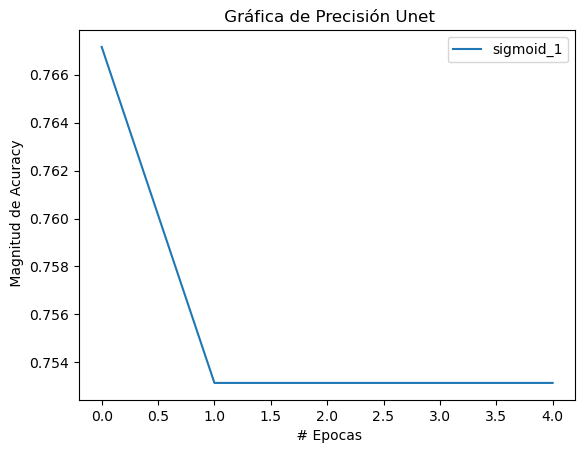

In [9]:
modelos = ['sigmoid_1','sigmoid_2',"tanh_1","tanh_2"]
plt.figure()
plt.title(f' Gráfica de Precisión Modelos Unet')
plt.xlabel(' # Epocas')
plt.ylabel(' Magnitud de Acuracy')
plt.grid()
ac_max = 0

for i,ac in enumerate(Acuracy):
    plt.plot(ac)
    print(f'Modelo {modelos[i]} Precisión : {ac[-1]}')

    if ac[-1] > ac_max:
        ac_max = ac[-1]
        model_final = modelos[i]

plt.legend(modelos)

path_save = os.path.join(path_save_modelos,"AcuracyModelos.png")
plt.savefig(path_save)

Modelo sigmoid_1 Precisión : 3.80774188041687


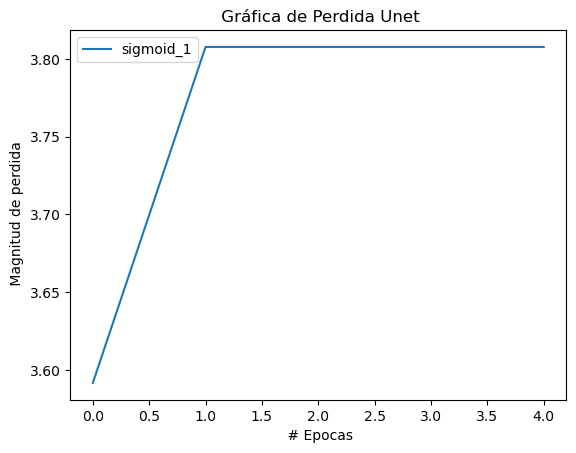

In [10]:
plt.figure()
plt.title(f' Gráfica de Perdida Modelos Unet')
plt.xlabel(' # Epocas')
plt.ylabel(' Magnitud de perdida')
plt.grid()

for i,ac in enumerate(Loss):
    plt.plot(ac)
    print(f'Modelo {modelos[i]} Precisión : {ac[-1]}')
plt.legend(modelos)

path_save = os.path.join(path_save_modelos,"AcuracyModelos.png")
plt.savefig(path_save)

In [ ]:
# Mover modelo final de carpeta
path_origen = os.path.join(path_save_modelos,model_final + ".keras")
path_destino = os.path.join(os.path.split(path_save_modelos)[0], "ModelSegmenta.keras")
shutil.copy(path_origen,path_destino)